# DLO Übung 9
von Fabian Rosenthal

In dieser Woche implementieren wir den Adam Optimierer und wenden ihn auf eine Testfunktion an.
Die Dachrinnen-Testfunktion aus der Vorlesung ist gegeben durch 
$$ f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$$
Sie spannt ein langes schmales Tal auf, in dem die Gradienten sehr klein sind. Da wir genau diese Funktion hinuntergehen möchten, ist sie auch zugleich die Fehlerfunktion.
Die Aufgabe ist es, den Adam Optimierer zu implementieren und zu testen, ob er es durchs Tal schafft.

Dafür definieren wir zunächst die Dachrinnen-Funktion und ihren Gradienten, der sich aus den partiellen Ableitungen nach $x_1$ und $x_2$ zusammensetzt:

$$ \frac{\partial f}{\partial x_1} = 0.4\cdot x_1$$
$$ \frac{\partial f}{\partial x_2} = 20\cdot x_2$$
Damit ist der Gradient gegeben durch:
$$ \nabla f = \begin{pmatrix} 0.4\cdot x_1 \\ 20\cdot x_2 \end{pmatrix}$$

In [145]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
def gutter(x):
    """Gives the value of the gutter function at (x_1, x_2)."""
    assert len(x) == 2
    return 0.2 * x[0]**2 + 10 * x[1]**2


def gutter_grad(x):
    """Gives the gradient of the gutter function at (x_1, x_2)."""
    assert len(x) == 2
    return np.array([0.4 * x[0], 20 * x[1]])


Nun implementieren wir den Optimierer. Dafür benötigen wir die folgenden Variablen:
- $\epsilon$ - die Lernrate
- $\rho_1$ - der Exponentialfaktor für den gleitenden Mittelwert des Gradienten
- $\rho_2$ - der Exponentialfaktor für den gleitenden Mittelwert des Gradientenquadrats
- $s$ - der gleitende Mittelwert des Gradienten
- $r$ - der gleitende Mittelwert des Gradientenquadrats
- $t$ - der Zeitschritt
- $\delta$ - ein kleiner Wert, um Division durch 0 zu vermeiden
- $\mu_{konvergenz}$ - ein kleiner Wert, um die Konvergenz zu definieren

Die Formeln für den Adam Optimierer sind gegeben durch:
$$ s_t = \rho_1\cdot s_{t-1} + (1-\rho_1)\cdot \nabla f(x_t)$$
$$ r_t = \rho_2\cdot r_{t-1} + (1-\rho_2)\cdot \nabla f(x_t)^2$$
$$ \hat{s}_t = \frac{s_t}{1-\rho_1^t}$$
$$ \hat{r}_t = \frac{r_t}{1-\rho_2^t}$$
$$ x_{t+1} = x_t - \epsilon\cdot \frac{\hat{s}_t}{\sqrt{\hat{r}_t}+\delta}$$

Die Konvergenzbedingung ist gegeben durch:
$$ \frac{f(x_t)-f(x_{t+1})}{f(x_t)} < \mu_{konvergenz}$$

Wir implementieren Adam als Klasse. Somit können wir neben der reinen Optimierungsfunktion auch noch weitere Hilfsfunktionen implementieren, die uns bei der Analyse und Auswertung helfen.


In [147]:

class AdamOptimizer:
    def __init__(self, rho, delta, eps, converge_mu):
        """Get the parameters for the Adam optimizer."""
        self.rho = rho
        self.delta = delta
        self.eps = eps
        self.converge_mu = converge_mu
        self.converged = False
        self.reached_max_iter = False
        
    def optimize(self, func, grad_func, x_start, w_decay=0.0, max_iter=1000):
        """
        Finds the minimum of a function using the Adam optimizer.
        
        Arguments:
        grad_func -- function that returns the gradient of the function to be optimized
        x_start -- starting point for the optimization
        
        Returns:
        x -- minimum of the gutter function
        
        """
        self.w_decay = w_decay
        x = np.array(x_start, dtype=np.float64)
        r = np.zeros_like(x, dtype=np.float64)
        s = np.zeros_like(x, dtype=np.float64)
        t = 0

        self.x_steps = [x[0]]
        self.y_steps = [x[1]]

        while not self.converged and not self.reached_max_iter:
            t += 1
            g = grad_func(x)
            
            if w_decay > 0:
                g += w_decay * x
                
            s = self.rho[0] * s + (1 - self.rho[0]) * g
            r = self.rho[1] * r + (1 - self.rho[1]) * g**2
            s_hat = s / (1 - self.rho[0]**t)
            r_hat = r / (1 - self.rho[1]**t)
            
            x_prev = x.copy()  # is used for convergence criterion
            x -= self.eps * s_hat / (np.sqrt(r_hat) + self.delta)
            
            # save steps
            self.x_steps.append(x[0])
            self.y_steps.append(x[1])
     
            relative_error = np.abs(func(x) - func(x_prev)) / np.abs(func(x_prev))
            if relative_error < self.converge_mu:
                self.t_max = t
                self.converged = True
                break
            if t == max_iter:
                self.t_max = t
                self.reached_max_iter = True
                break
        return x
    
    def print_time_to_converge(self):
        """Prints the number of iterations that were needed to converge."""
        if self.reached_max_iter:
            print(f"Reached max iterations.")
        elif self.converged:
            print(f"Performed {self.t_max} iterations and the algorithm converged.")
        else:
            print(f"Performed {self.t_max} iterations and have not converged.")


    def plot(self, func, x_range, y_range, func_title, view):
        """
        This function creates a 3D meshgrid plot of the function values of func in the x_range and y_range.
        Then, the x steps used in the Adam optimization are plotted as lines and scatters in the plot, so that the path is shown until the algorithm converges.
        """
        x_steps = self.x_steps
        y_steps = self.y_steps
        
        fig = plt.figure(figsize=(5, 5), dpi=150)
        ax = fig.add_subplot(111, projection='3d')

        # Create meshgrid
        x_vals = np.linspace(x_range[0], x_range[1], 100)
        y_vals = np.linspace(y_range[0], y_range[1], 100)
        x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
        z_mesh = func((x_mesh, y_mesh))

        # Plot meshgrid
        ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='viridis', alpha=0.8, zorder=1)

        # Plot optimization path
        x_steps = np.array(x_steps)
        y_steps = np.array(y_steps)
        z_steps = func((x_steps, y_steps))
        
        ax.plot(x_steps, y_steps, z_steps, 'r', label=f'Adam Optimization Path', zorder=2)
        ax.scatter(x_steps, y_steps, z_steps, c='r', s=20, zorder=3)

        # Make the plot look nice
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        ax.set_title(f"Adam Optimization for {func_title}", fontsize=12)
        
        # make a small text box with information about the optimization parameters
        textstr = f"""
        rho = {self.rho}
        delta = {self.delta}
        eps = {self.eps}
        weigh decay = {self.w_decay}
        converge_eps = {self.converge_mu}
        Time to converge: {self.t_max} it
        """
        # add textstr to the bottom right of the plot
        # the text should be left aligned inside the box
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.3)
        ax.text(0.05, 0.05, 0.05, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='bottom',
                bbox=props)

        # set the view of the plot
        ax.view_init(elev=view[0], azim=view[1])
        plt.show()
        
    def get_steps(self):
        return self.x_steps, self.y_steps

Nun aber ran ans Experiment! Lernrate $\epsilon$ auf 1 gesetzt und los! Die Ergebnisplots betrachten wir am besten von zwei Blickwinkeln.


Minimum of the gutter function: [-8.19379597e-05 -8.76816692e-06]
Performed 222 iterations and the algorithm converged.


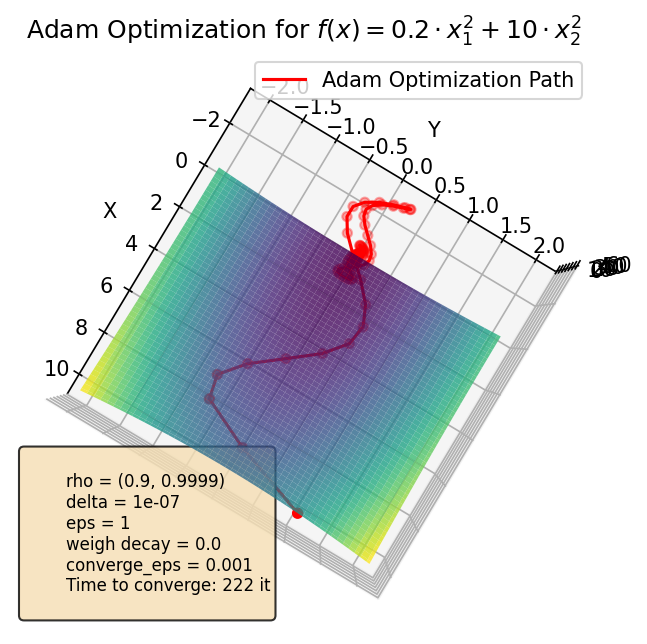

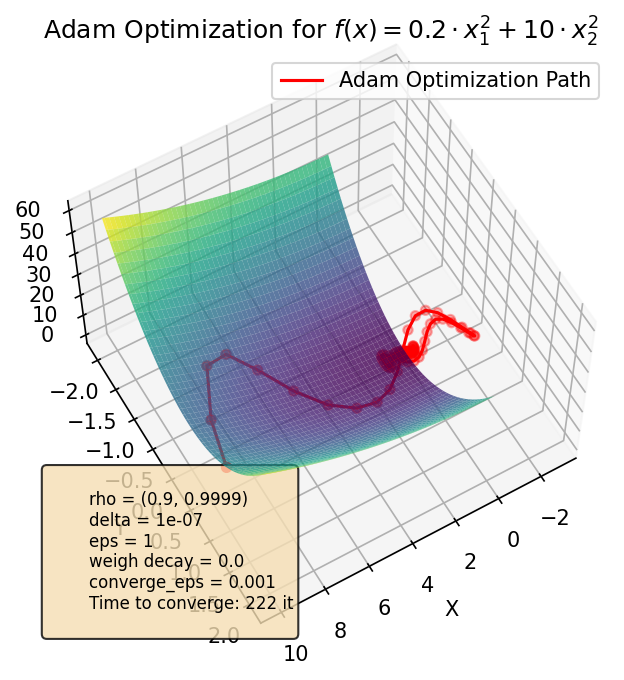

In [148]:
adam = AdamOptimizer(
    rho=(0.9, 0.9999),
    delta=10e-8,
    eps=1,
    converge_mu=1e-3
    )

x = adam.optimize(
    func=gutter,
    grad_func=gutter_grad,
    x_start=(10, 1),
    w_decay=0.0,
    max_iter=1000
    )

print(f"Minimum of the gutter function: {x}")
adam.print_time_to_converge()
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(90, 30)
    )

adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(60, 60)
    )

Wir sehen, dass der Adam Algorithmus noch nicht konvergiert ist. Er hat einfach die maximale Anzahl Iterationen erreicht. Er bummelt in Schlangenlinien ums Optimum herum. Dann wollen wir Adam mal von der Leine lassen:

Minimum of the gutter function: [-8.19379597e-05 -8.76816692e-06]
Performed 222 iterations and the algorithm converged.


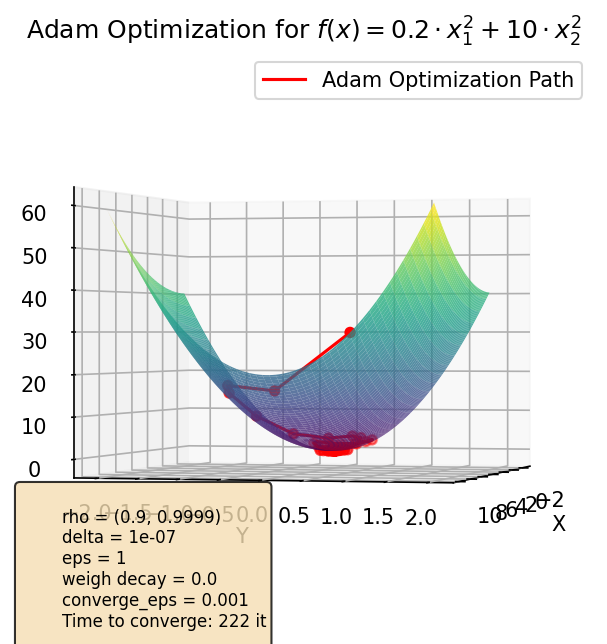

In [149]:
adam = AdamOptimizer(
    rho=(0.9, 0.9999),
    delta=10e-8,
    eps=1,
    converge_mu=1e-3,
    )

x = adam.optimize(
    func=gutter,
    grad_func=gutter_grad,
    x_start=(10, 1),
    w_decay=0.0,
    max_iter=10_000
    )

print(f"Minimum of the gutter function: {x}")
adam.print_time_to_converge()
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(0, 15)
    )



Nach 10.000 Iterationen wird es noch nicht besser. Adam springt wild hin und her! Jetzt adjustieren wir die globale Lernrate $\epsilon$ auf 0.1:

C:\Users\rosen\AppData\Local\Temp\ipykernel_10852\2691567556.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  relative_error = np.abs(func(x) - func(x_prev)) / np.abs(func(x_prev))


Minimum of the gutter function: [ 2.88990673e-161 -2.30655456e-165]
Performed 7205 iterations and the algorithm converged.


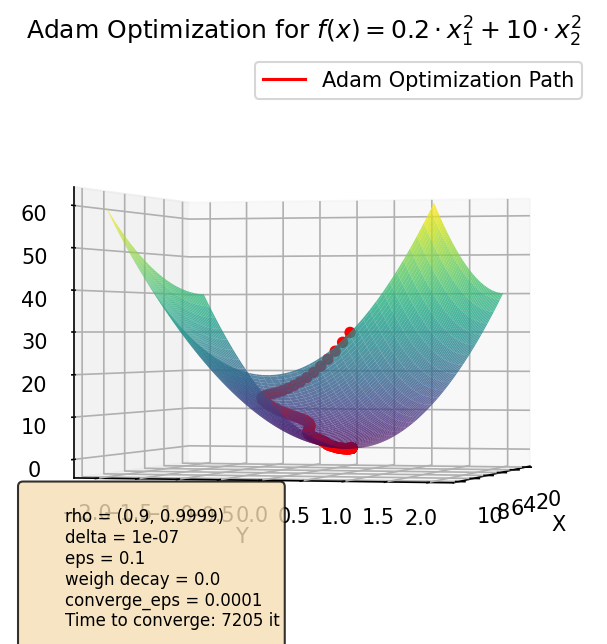

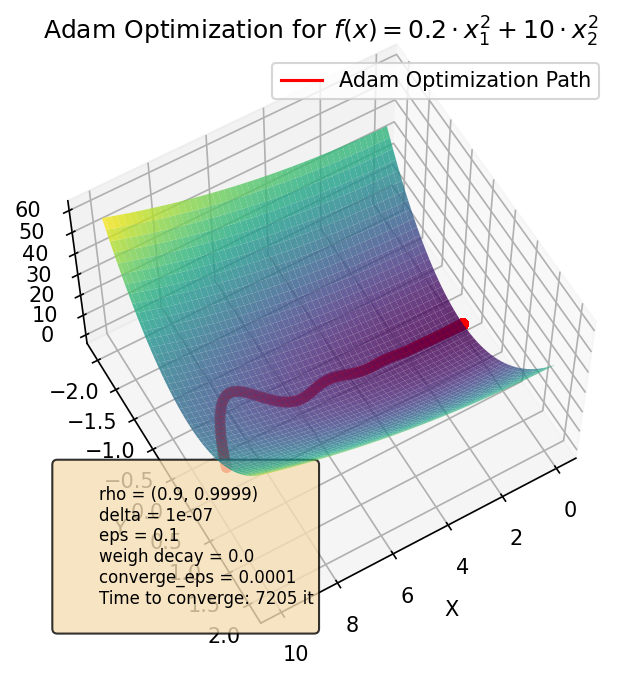

In [150]:
adam = AdamOptimizer(
    rho=(0.9, 0.9999),
    delta=10e-8,
    eps=0.1,
    converge_mu=1e-4,
    )

x = adam.optimize(
    func=gutter,
    grad_func=gutter_grad,
    x_start=(10, 1),
    w_decay=0.0,
    max_iter=10_000
    )

print(f"Minimum of the gutter function: {x}")
adam.print_time_to_converge()
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(0, 15)
    )
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(60, 60)
    )


Und siehe da, wir erhalten ein Ergebnis wo Adam konvergiert ist! Wie sieht das ganze mit Weight Decay aus?

Minimum of the gutter function: [ 5.04235182e-40 -4.47893364e-41]
Performed 1760 iterations and the algorithm converged.


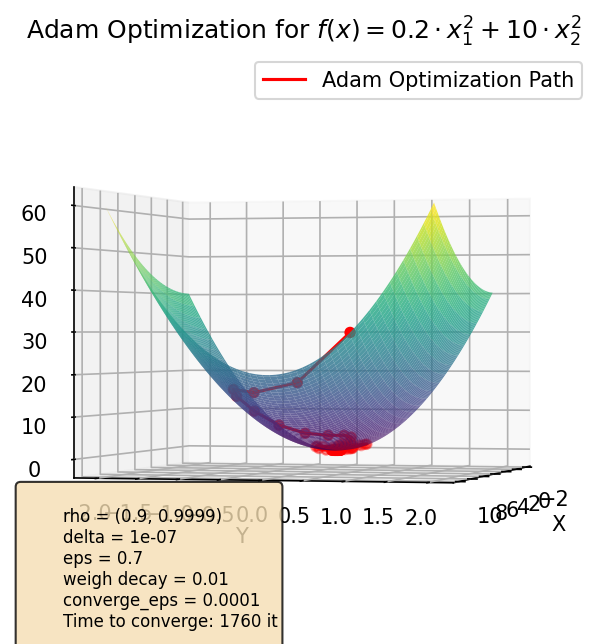

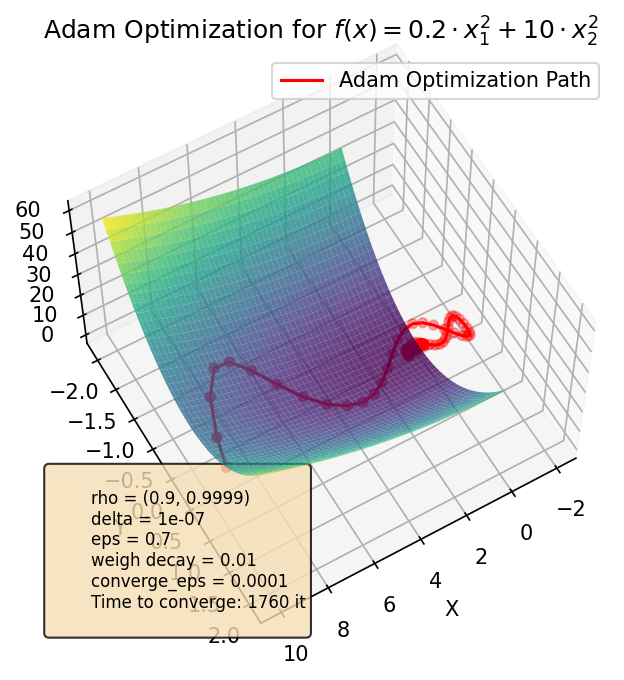

In [151]:
adam = AdamOptimizer(
    rho=(0.9, 0.9999),
    delta=10e-8,
    eps=0.7,
    converge_mu=1e-4,
    )

x = adam.optimize(
    func=gutter,
    grad_func=gutter_grad,
    x_start=(10, 1),
    w_decay=0.01,
    max_iter=10_000
    )

print(f"Minimum of the gutter function: {x}")
adam.print_time_to_converge()
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(0, 15)
    )
adam.plot(
    func=gutter, 
    x_range=(0, 10), 
    y_range=(-2, 2), 
    func_title=r"$f(x) = 0.2\cdot x_1^2 + 10\cdot x_2^2$",
    view=(60, 60)
    )

Wir sehen hier, dasss wir wieder mehr übers Ziel hinausschießen. Allerdings sind wir dennoch früher da und erfüllen die selbstgewählte Konvergenzbedingung. Man kann also ein gutes Mittelmaß finden zwischen schneller Konvergenz und guter Lösung wenn man die globale Lernrate und die L2 Strafe durch Weight Decay (Zerfall der Gewichte) entsprechend anpasst.